Skin cancer detection

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#%load_ext autoreload
#%autoreload 2

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/validation (132 images), and reshape them
#val_generator = ImageDataGenerator().flow_from_directory(
#        val_data_dir, classes=['test'])

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


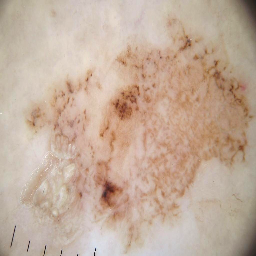

In [3]:
# Preview an image
array_to_img(train_images[0])

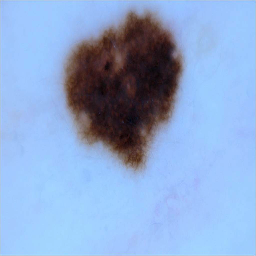

In [4]:
# Preview an image
array_to_img(test_images[0])

In [5]:
train_labels.shape

(2239, 9)

In [6]:
test_labels.shape

(118, 9)

In [7]:
test_images.shape

(118, 256, 256, 3)

In [8]:
train_images.shape

(2239, 256, 256, 3)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
type(train_labels)

numpy.ndarray

In [11]:
type(train_images)

numpy.ndarray

In [12]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [13]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2237,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9064e2a4e0>,
      dtype=object)

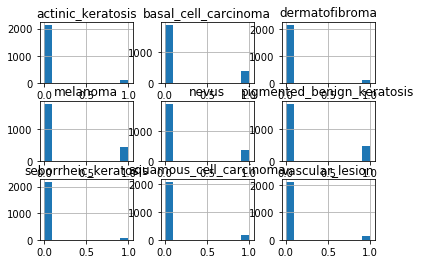

In [14]:
dataframe.hist()

In [15]:
sums=dataframe.sum(axis=0)

In [16]:
sums=pd.DataFrame(sums)

In [17]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [18]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [19]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


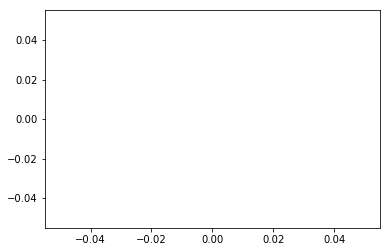

In [20]:
plt.plot(x=sums.index, y=sums['%']);

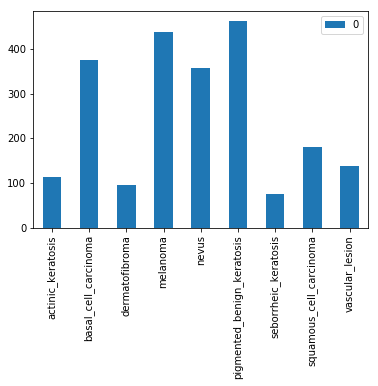

In [21]:
sums.plot(kind='bar');

In [22]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [23]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
print(train_img.shape)
print(test_img.shape)

(2239, 196608)
(118, 196608)


In [24]:
train_y = np.reshape(train_labels[:,0], (2239,1))
test_y = np.reshape(test_labels[:,0], (118,1))

In [25]:
X=train_img
y=train_y

In [26]:
model1 = Sequential()

In [27]:
model1.add(layers.Flatten())
model1.add(Dense(24, activation='relu', input_shape=(196608,)))
model1.add(Dense(12, activation='relu'))
model1.add(Dense(9, activation='softmax'))

In [28]:
model1.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
#model1.fit(X, y, epochs=50, batch_size=10)

The model did very well almost right away, 95% accuracy already at the fourth epoch.
Let us explore a bit more loss and accuracy using also a validation split.

In [30]:
results1 = model1.fit(X, y, epochs=20, batch_size=10, validation_split=0.2)

Epoch 1/20
180/180 [==============================] - 12s 62ms/step - loss: 883.4429 - accuracy: 0.8509 - val_loss: 1.9307 - val_accuracy: 0.9531
Epoch 2/20
180/180 [==============================] - 10s 53ms/step - loss: 1.6782 - accuracy: 0.9481 - val_loss: 1.3722 - val_accuracy: 0.9531
Epoch 3/20
180/180 [==============================] - 10s 54ms/step - loss: 1.0511 - accuracy: 0.9481 - val_loss: 0.7338 - val_accuracy: 0.9531
Epoch 4/20
180/180 [==============================] - 10s 55ms/step - loss: 0.5211 - accuracy: 0.9481 - val_loss: 0.3399 - val_accuracy: 0.9531
Epoch 5/20
180/180 [==============================] - 9s 53ms/step - loss: 0.2833 - accuracy: 0.9481 - val_loss: 0.2283 - val_accuracy: 0.9531
Epoch 6/20
180/180 [==============================] - 10s 53ms/step - loss: 0.2329 - accuracy: 0.9481 - val_loss: 0.2068 - val_accuracy: 0.9531
Epoch 7/20
180/180 [==============================] - 9s 52ms/step - loss: 0.2188 - accuracy: 0.9481 - val_loss: 0.1981 - val_accuracy:

In [31]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

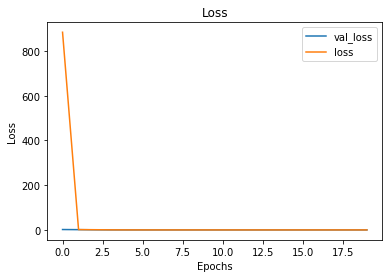

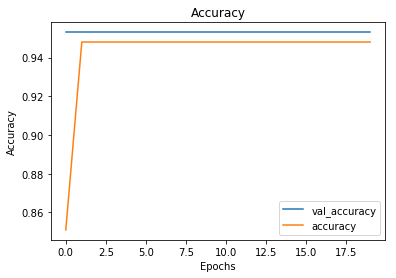

In [32]:
visualize_training_results(results1)

I just want to see out of curiosity what is the performance, with the same exact parameters, if I were to import the images in a smaller size.

In [33]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator64 = ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=10)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator64 = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=20)


# Create the datasets
train_images64, train_labels64 = next(train_generator64)
test_images64, test_labels64 = next(test_generator64)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [34]:
train_img64 = train_images64.reshape(train_images64.shape[0], -1)
test_img64 = test_images64.reshape(test_images64.shape[0], -1)
print(train_img64.shape)
print(test_img64.shape)

(20, 12288)
(10, 12288)


In [35]:
train_y64 = np.reshape(train_labels64[:,0], (20,1))
test_y64 = np.reshape(test_labels64[:,0], (10,1))

In [36]:
X64=train_img64
y64=train_y64

In [37]:
model2 = Sequential()

In [38]:
model2.add(Dense(24, activation='relu', input_shape=(12288,)))
model2.add(Dense(12, activation='relu'))
model2.add(Dense(9, activation='softmax'))

In [39]:
model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
#model2.fit(X64, y64, epochs=50, batch_size=10)

In [41]:
results2 = model2.fit(X64, y64, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 1s 139ms/step - loss: 643.3134 - accuracy: 0.0625 - val_loss: 426.5131 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 0s 36ms/step - loss: 428.9530 - accuracy: 0.0625 - val_loss: 113.2549 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 0s 48ms/step - loss: 114.8349 - accuracy: 0.0000e+00 - val_loss: 123.8663 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 0s 52ms/step - loss: 138.4702 - accuracy: 0.0000e+00 - val_loss: 100.6298 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 0s 58ms/step - loss: 107.4345 - accuracy: 0.0000e+00 - val_loss: 71.4390 - val_accuracy: 0.0000e+00


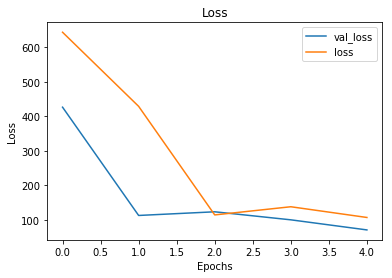

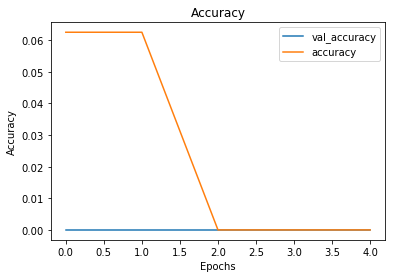

In [42]:
visualize_training_results(results2)

In [43]:
history2 = results2.history
history2

{'loss': [643.3133544921875,
  428.9530334472656,
  114.83488464355469,
  138.47015380859375,
  107.43450927734375],
 'accuracy': [0.0625, 0.0625, 0.0, 0.0, 0.0],
 'val_loss': [426.5130920410156,
  113.25493621826172,
  123.8663330078125,
  100.62981414794922,
  71.43899536132812],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}

Look at lab on https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
might need to do some one hot encoding.
Also, just like it shows there, as a naive model maybe decrease the number of layers and keep epochs at like 5.
If results are the same, try to understand why the loss still showes such high peaks.And why the accuracy drops like that.
Might also be worth doing CNN from the start with 2D layers instead of this basic NN.

### Maybe another possible naive:

In [44]:
model3 = Sequential()
model3.add(Dense(12, activation='tanh', input_shape=(12288,)))
model3.add(Dense(9, activation='softmax'))

In [45]:
model3.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
results3 = model3.fit(X64, y64, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 1s 459ms/step - loss: 1.4704 - accuracy: 0.6875 - val_loss: 1.1202 - val_accuracy: 1.0000
Epoch 2/5
2/2 [==============================] - 0s 45ms/step - loss: 1.2763 - accuracy: 0.9375 - val_loss: 1.0593 - val_accuracy: 1.0000
Epoch 3/5
2/2 [==============================] - 0s 36ms/step - loss: 1.2204 - accuracy: 0.9375 - val_loss: 1.0112 - val_accuracy: 1.0000
Epoch 4/5
2/2 [==============================] - 0s 30ms/step - loss: 1.1753 - accuracy: 0.9375 - val_loss: 0.9698 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 0s 33ms/step - loss: 1.1367 - accuracy: 0.9375 - val_loss: 0.9341 - val_accuracy: 1.0000


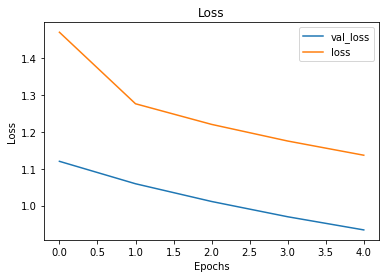

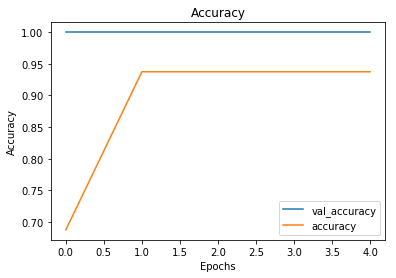

In [47]:
visualize_training_results(results3)

In [48]:
# changing batch size to 1
results4 = model3.fit(X64, y64, epochs=5, batch_size=1, validation_split=0.2)

Epoch 1/5
16/16 [==============================] - 0s 12ms/step - loss: 1.0063 - accuracy: 0.9375 - val_loss: 0.7108 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 0s 6ms/step - loss: 0.8255 - accuracy: 0.9375 - val_loss: 0.5485 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.9375 - val_loss: 0.4240 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.5891 - accuracy: 0.9375 - val_loss: 0.3284 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 0s 6ms/step - loss: 0.5131 - accuracy: 0.9375 - val_loss: 0.2556 - val_accuracy: 1.0000


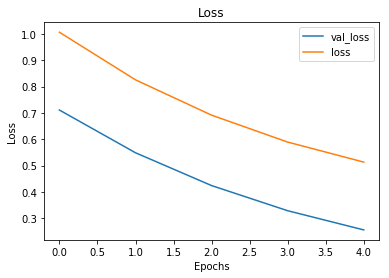

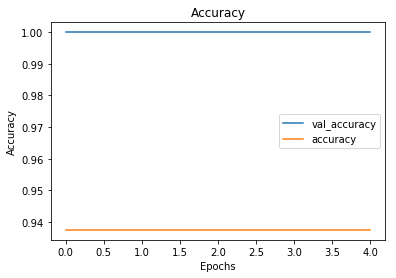

In [49]:
visualize_training_results(results4)

In [50]:
# increasing batch size to 20
results5 = model3.fit(X64, y64, epochs=5, batch_size=20, validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 0s 56ms/step - loss: 0.4770 - accuracy: 0.9375 - val_loss: 0.2519 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 0.4736 - accuracy: 0.9375 - val_loss: 0.2482 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 32ms/step - loss: 0.4702 - accuracy: 0.9375 - val_loss: 0.2445 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 45ms/step - loss: 0.4668 - accuracy: 0.9375 - val_loss: 0.2409 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 53ms/step - loss: 0.4635 - accuracy: 0.9375 - val_loss: 0.2373 - val_accuracy: 1.0000


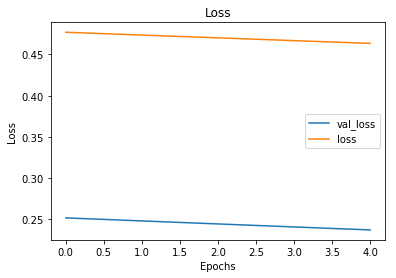

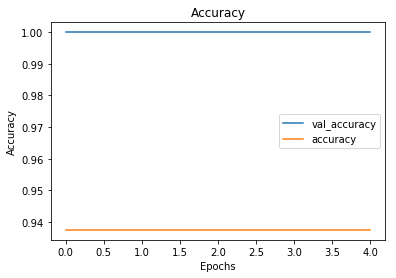

In [51]:
visualize_training_results(results5)

One more attempt at a naive model:
<br>since these ones keep performing even too well.
<br>I decrease again the size of the images, batch size and also number of neurons.

In [52]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator32= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=5)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator32 = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=10)

# Create the datasets
train_images32, train_labels32 = next(train_generator32)
test_images32, test_labels32 = next(test_generator32)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [53]:
train_img32 = train_images32.reshape(train_images32.shape[0], -1)
test_img32 = test_images32.reshape(test_images32.shape[0], -1)
print(train_img32.shape)
print(test_img32.shape)

(10, 3072)
(5, 3072)


In [54]:
train_y32 = np.reshape(train_labels32[:,0], (10,1))
test_y32 = np.reshape(test_labels32[:,0], (5,1))

In [55]:
X32=train_img32
y32=train_y32

In [56]:
model6 = Sequential()

In [57]:
model6.add(Dense(11, activation='relu', input_shape=(3072,)))
model6.add(Dense(10, activation='relu'))
model6.add(Dense(9, activation='softmax'))

In [58]:
model6.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
results6 = model6.fit(X32, y32, epochs=5, batch_size=5, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 1s 138ms/step - loss: 132.3683 - accuracy: 0.0000e+00 - val_loss: 71.6226 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 0s 33ms/step - loss: 106.5416 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
2/2 [==============================] - 0s 33ms/step - loss: 96.7095 - accuracy: 0.8750 - val_loss: 23.3323 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 0s 34ms/step - loss: 34.4539 - accuracy: 0.3750 - val_loss: 2.1839 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 0s 30ms/step - loss: 2.3594 - accuracy: 0.8750 - val_loss: 2.1777 - val_accuracy: 1.0000


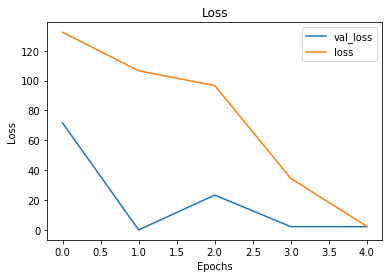

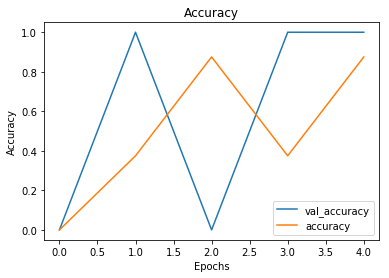

In [60]:
visualize_training_results(results6)

Even better, this does not make any sense.

Let us forget about all of this and try with the 2D actual convolutional neural network for images. The perfmormance there might be different.

We can also do something else which is group together the types of skin abnormalities that are cancerous and the ones that are not, reducing the classes to 2 and making this a binary classification problem.
I will do that later on. For now let's see what happens with a convolutional neural network, which is what I should be doing anyway.

## CNN

In [61]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [62]:
# Explore your dataset again
m_train = train_img.shape[0]
num_px = train_img.shape[1]
m_test = test_img.shape[0]
#m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
#print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_lab.shape))
#print ("val_images shape: " + str(val_images.shape))
#print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 32, 32, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 32, 32, 3)
test_labels shape: (118, 9)


In [63]:
#train_img = train_img.reshape(train_img.shape[0], -1)
#test_img = test_img.reshape(test_img.shape[0], -1)
#val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
#print(val_img.shape)

(2239, 32, 32, 3)
(118, 32, 32, 3)


In [64]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [65]:
#This is too good I'll just cut it out
"""model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
#                         input_shape=(3072)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(10, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])"""

"model = models.Sequential()\nmodel.add(layers.Conv2D(10, (3, 3), activation='relu',\n                        input_shape=(32 ,32,  3)))\n#                         input_shape=(3072)))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\nmodel.add(layers.Conv2D(10, (4, 4), activation='relu'))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\nmodel.add(layers.Conv2D(32, (3, 3), activation='relu'))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(32, activation='relu'))\nmodel.add(layers.Dense(9, activation='softmax'))\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['acc'])"

In [66]:
#history = model.fit(train_img,
#                    train_y,
#                    epochs=30,
#                    batch_size=10, validation_split=0.2)

In [67]:
#history.history

In [68]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [69]:
#visualize_training_results(history)

Trying with a simple model:

In [70]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(10, (4, 4), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

And doing only 10 epochs:

In [71]:
history1 = model.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 2s 9ms/step - loss: 23.6577 - acc: 0.8724 - val_loss: 1.6649 - val_acc: 0.6875
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.8906 - acc: 0.9081 - val_loss: 0.4476 - val_acc: 0.9554
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3938 - acc: 0.9247 - val_loss: 2.6112 - val_acc: 0.9554
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2986 - acc: 0.9330 - val_loss: 0.6185 - val_acc: 0.9405
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2454 - acc: 0.9413 - val_loss: 0.6486 - val_acc: 0.9405
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2835 - acc: 0.9419 - val_loss: 0.5667 - val_acc: 0.9211
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2874 - acc: 0.9394 - val_loss: 0.4680 - val_acc: 0.9152
Epoch 8/10
157/157 [==============================] - 1s 7ms/step - loss: 0

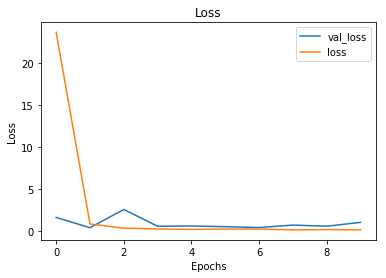

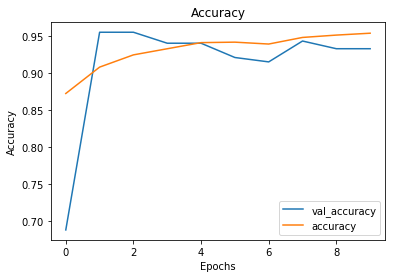

In [72]:
visualize_training_results(history1)

In [73]:
history1.history['acc']

[0.8723675608634949,
 0.908104658126831,
 0.9246968626976013,
 0.9329929947853088,
 0.9412890672683716,
 0.9419272541999817,
 0.9393746256828308,
 0.9483088850975037,
 0.9514997005462646,
 0.9540523290634155]

In [74]:
results=[]
results.append('32 bits first model')
results.append(['acc train',round(history1.history['acc'][-1],3)])
results.append(['acc valid',round(history1.history['val_acc'][-1],3)])
results.append(['loss train',round(history1.history['loss'][-1],3)])
results.append(['loss valid',round(history1.history['val_loss'][-1],3)])

In [75]:
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082]]

Let me try with a larger batch size:

In [76]:
history2 = model.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 20ms/step - loss: 0.1308 - acc: 0.9598 - val_loss: 0.5408 - val_acc: 0.9330
Epoch 2/10
36/36 [==============================] - 1s 23ms/step - loss: 0.1214 - acc: 0.9570 - val_loss: 0.4695 - val_acc: 0.9241
Epoch 3/10
36/36 [==============================] - 1s 20ms/step - loss: 0.1083 - acc: 0.9598 - val_loss: 0.7130 - val_acc: 0.9464
Epoch 4/10
36/36 [==============================] - 1s 18ms/step - loss: 0.1110 - acc: 0.9587 - val_loss: 1.7548 - val_acc: 0.9397
Epoch 5/10
36/36 [==============================] - 1s 17ms/step - loss: 0.1053 - acc: 0.9615 - val_loss: 0.5912 - val_acc: 0.9375
Epoch 6/10
36/36 [==============================] - 1s 19ms/step - loss: 0.1363 - acc: 0.9604 - val_loss: 1.0477 - val_acc: 0.9196
Epoch 7/10
36/36 [==============================] - 1s 19ms/step - loss: 0.0918 - acc: 0.9620 - val_loss: 0.6263 - val_acc: 0.9308
Epoch 8/10
36/36 [==============================] - 1s 20ms/step - loss: 0.0846 - a

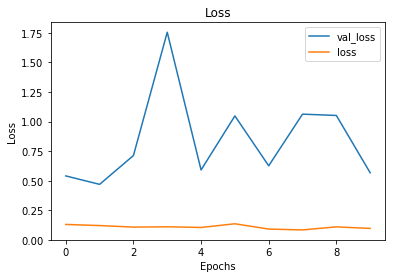

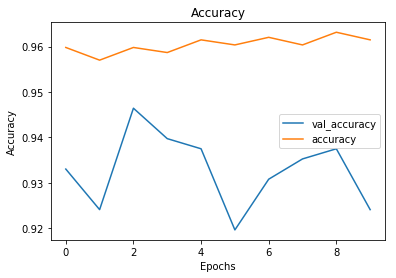

In [77]:
visualize_training_results(history2)

In [78]:
results.append('32 bits second model, larger batch')
results.append(['acc train',round(history2.history['acc'][-1],3)])
results.append(['acc valid',round(history2.history['val_acc'][-1],3)])
results.append(['loss train',round(history2.history['loss'][-1],3)])
results.append(['loss valid',round(history2.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568]]

Last attempt: all the previous parameters but making the last dense layer smaller.

In [79]:
model2 = models.Sequential()
model2.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [80]:
history3 = model2.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 23ms/step - loss: 15.1761 - acc: 0.8453 - val_loss: 9.1036 - val_acc: 0.4018
Epoch 2/10
36/36 [==============================] - 1s 19ms/step - loss: 4.6276 - acc: 0.8911 - val_loss: 1.0816 - val_acc: 0.9531
Epoch 3/10
36/36 [==============================] - 1s 18ms/step - loss: 0.6329 - acc: 0.9006 - val_loss: 0.3260 - val_acc: 0.8973
Epoch 4/10
36/36 [==============================] - 1s 18ms/step - loss: 0.2863 - acc: 0.9296 - val_loss: 0.2448 - val_acc: 0.9420
Epoch 5/10
36/36 [==============================] - 1s 19ms/step - loss: 0.2448 - acc: 0.9324 - val_loss: 0.2274 - val_acc: 0.9308
Epoch 6/10
36/36 [==============================] - 1s 17ms/step - loss: 0.2493 - acc: 0.9341 - val_loss: 0.3089 - val_acc: 0.9263
Epoch 7/10
36/36 [==============================] - 1s 19ms/step - loss: 0.2376 - acc: 0.9302 - val_loss: 0.4337 - val_acc: 0.9375
Epoch 8/10
36/36 [==============================] - 1s 20ms/step - loss: 0.2019 - 

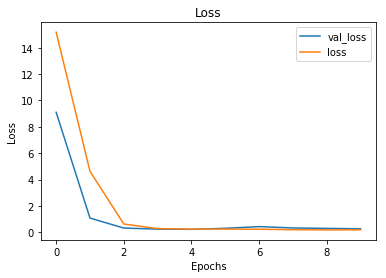

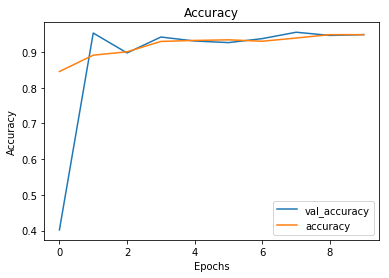

In [81]:
visualize_training_results(history3)

In [82]:
results.append('32 bits third model, less neurons in last layer')
results.append(['acc train',round(history3.history['acc'][-1],3)])
results.append(['acc valid',round(history3.history['val_acc'][-1],3)])
results.append(['loss train',round(history3.history['loss'][-1],3)])
results.append(['loss valid',round(history3.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268]]

Even less Neurons:

In [83]:
model3 = models.Sequential()
model3.add(layers.Conv2D(5, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(9, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [84]:
history4 = model3.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 19ms/step - loss: 3.2930 - acc: 0.8800 - val_loss: 0.2339 - val_acc: 0.9531
Epoch 2/10
36/36 [==============================] - 1s 16ms/step - loss: 0.2317 - acc: 0.9475 - val_loss: 0.2957 - val_acc: 0.9531
Epoch 3/10
36/36 [==============================] - 1s 18ms/step - loss: 0.2229 - acc: 0.9475 - val_loss: 0.2088 - val_acc: 0.9554
Epoch 4/10
36/36 [==============================] - 1s 16ms/step - loss: 0.2216 - acc: 0.9475 - val_loss: 0.1873 - val_acc: 0.9554
Epoch 5/10
36/36 [==============================] - 1s 17ms/step - loss: 0.2111 - acc: 0.9475 - val_loss: 0.1780 - val_acc: 0.9554
Epoch 6/10
36/36 [==============================] - 1s 17ms/step - loss: 0.2177 - acc: 0.9475 - val_loss: 0.1839 - val_acc: 0.9554
Epoch 7/10
36/36 [==============================] - 1s 17ms/step - loss: 0.2051 - acc: 0.9475 - val_loss: 0.1858 - val_acc: 0.9554
Epoch 8/10
36/36 [==============================] - 1s 17ms/step - loss: 0.2040 - a

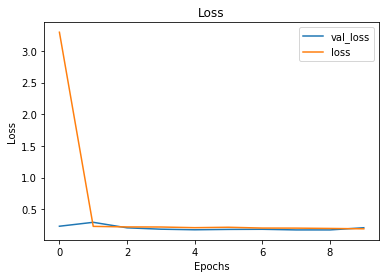

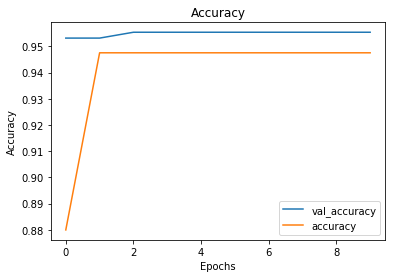

In [85]:
visualize_training_results(history4)

In [86]:
results.append('32 bits fourth model, less neurons overall')
results.append(['acc train',round(history4.history['acc'][-1],3)])
results.append(['acc valid',round(history4.history['val_acc'][-1],3)])
results.append(['loss train',round(history4.history['loss'][-1],3)])
results.append(['loss valid',round(history4.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21]]

No that doesn't change. Ok.
Let's move on and try to improve our model.

#### No sorry one more thing. Even less resolution images.

In [87]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [88]:
# Explore your dataset again
m_train = train_img.shape[0]
num_px = train_img.shape[1]
m_test = test_img.shape[0]
#m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
#print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 8, 8, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 8, 8, 3)
test_labels shape: (118, 9)


In [89]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [90]:
model5 = models.Sequential()
model5.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Flatten())
#model5.add(layers.Dense(3, activation='relu'))
model5.add(layers.Dense(9, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [91]:
history5 = model5.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 2s 5ms/step - loss: 5.9474 - acc: 0.8545 - val_loss: 0.7501 - val_acc: 0.9405
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.9755 - acc: 0.8909 - val_loss: 0.5706 - val_acc: 0.8914
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.7343 - acc: 0.8883 - val_loss: 0.5037 - val_acc: 0.9092
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.6041 - acc: 0.9030 - val_loss: 0.4643 - val_acc: 0.9405
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5286 - acc: 0.8973 - val_loss: 0.4130 - val_acc: 0.9360
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.4672 - acc: 0.9024 - val_loss: 0.4688 - val_acc: 0.9479
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.4589 - acc: 0.9017 - val_loss: 0.4239 - val_acc: 0.9449
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.

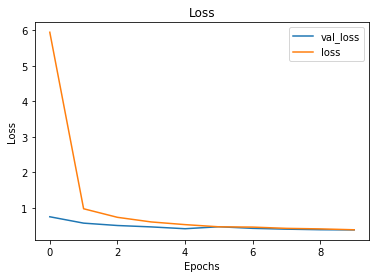

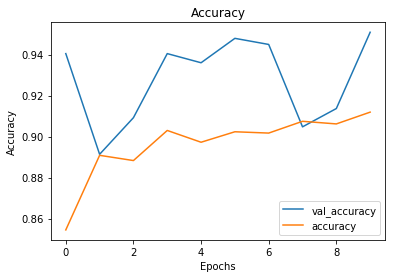

In [92]:
visualize_training_results(history5)

In [93]:
results.append('8 bits fifth model')
results.append(['acc train',round(history5.history['acc'][-1],3)])
results.append(['acc valid',round(history5.history['val_acc'][-1],3)])
results.append(['loss train',round(history5.history['loss'][-1],3)])
results.append(['loss valid',round(history5.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21],
 '8 bits fifth model',
 ['acc train', 0.912],
 ['acc valid', 0.951],
 ['loss train', 0.384],
 ['loss valid', 0.38]]

The good news is that even if the results change a lot in the first part where I do regualr NN, every time I run the code, they don't change so radically with the CNN.
I will keep track a bit but overall it seems like I can stop worrying about reproducibe results, if I use CNN right away.

## Starting to improve our model:

Taking from the german signs notebook

Nope. It's in AWS Sagemaker. But I can look back at it and use either a simple pipeline for loading and changing the size of the images, or for images augmentation to balance the classes of the different skin anomalies.
<br>A simple pipeline can even be "load, normalize, augment".

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - change activation function and optimization
    
After we have done all this we will select the best performing model and we will also group up into 2 classes, cancerous and benign growth too.
<br>Maybe I should do that now actually.
<br>No I will do it after this first selection so I can say I have a good model to predict which of the 9 classes with this much accuracy.
<br>And then introduce the concept of two classes and decreasing recall.
<br>After that anyhow, do another round of tuning for the model, this time using:
 - drop out layers
 - regularization
 - normalization
 - data augmentation
 - balancing classes with data augmentation
 

### Improving the model with 9 classes:

#### Normalize the data:

To standardize the pixel values:

In [94]:
train_img /= 255.
test_img /= 255.

In [95]:
train_img

array([[[[0.6431373 , 0.5254902 , 0.57254905],
         [0.7294118 , 0.5568628 , 0.5529412 ],
         [0.8       , 0.61960787, 0.627451  ],
         ...,
         [0.8509804 , 0.6862745 , 0.69411767],
         [0.76862746, 0.6431373 , 0.6627451 ],
         [0.57254905, 0.46666667, 0.42352942]],

        [[0.69803923, 0.56078434, 0.5764706 ],
         [0.8       , 0.65882355, 0.6745098 ],
         [0.8235294 , 0.6862745 , 0.7137255 ],
         ...,
         [0.87058824, 0.73333335, 0.75686276],
         [0.76862746, 0.5764706 , 0.54901963],
         [0.73333335, 0.627451  , 0.64705884]],

        [[0.7254902 , 0.6039216 , 0.627451  ],
         [0.8156863 , 0.6392157 , 0.65882355],
         [0.83137256, 0.6862745 , 0.7137255 ],
         ...,
         [0.7254902 , 0.60784316, 0.64705884],
         [0.8156863 , 0.6627451 , 0.63529414],
         [0.7294118 , 0.6313726 , 0.6117647 ]],

        ...,

        [[0.7254902 , 0.5764706 , 0.61960787],
         [0.7921569 , 0.62352943, 0.65882355]

In [96]:
history52 = model5.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 0.6502 - acc: 0.9432 - val_loss: 0.1721 - val_acc: 0.9628
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2274 - acc: 0.9432 - val_loss: 0.1735 - val_acc: 0.9628
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2250 - acc: 0.9432 - val_loss: 0.1757 - val_acc: 0.9628
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2218 - acc: 0.9432 - val_loss: 0.1867 - val_acc: 0.9628
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2233 - acc: 0.9432 - val_loss: 0.1660 - val_acc: 0.9628
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2228 - acc: 0.9432 - val_loss: 0.1684 - val_acc: 0.9628
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.2192 - acc: 0.9432 - val_loss: 0.1701 - val_acc: 0.9628
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.

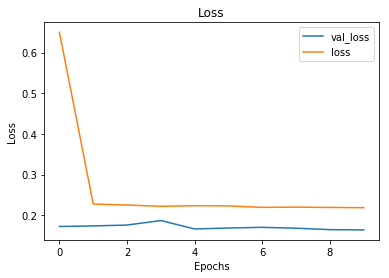

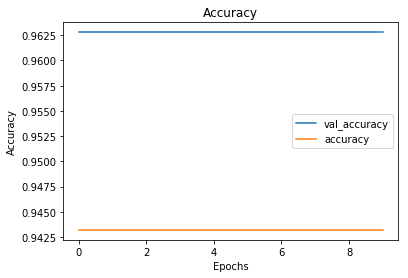

In [97]:
visualize_training_results(history52)

In [98]:
results.append('8 bits 5th model, normalized pixels')
results.append(['acc train',round(history52.history['acc'][-1],3)])
results.append(['acc valid',round(history52.history['val_acc'][-1],3)])
results.append(['loss train',round(history52.history['loss'][-1],3)])
results.append(['loss valid',round(history52.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21],
 '8 bits fifth model',
 ['acc train', 0.912],
 ['acc valid', 0.951],
 ['loss train', 0.384],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.943],
 ['acc valid', 0.963],
 ['loss train', 0.218],
 ['loss valid', 0.164]]

#### Increasing Image resolution:

In [99]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)
#normalizing again
train_img /= 255.
test_img /= 255.

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [100]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [101]:
model6 = models.Sequential()
model6.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Flatten())
#model5.add(layers.Dense(3, activation='relu'))
model6.add(layers.Dense(9, activation='softmax'))

model6.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [102]:
history6 = model6.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 3s 15ms/step - loss: 0.2678 - acc: 0.9432 - val_loss: 0.2419 - val_acc: 0.9524
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2077 - acc: 0.9477 - val_loss: 0.2321 - val_acc: 0.9524
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2033 - acc: 0.9477 - val_loss: 0.3027 - val_acc: 0.9524
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2044 - acc: 0.9477 - val_loss: 0.2441 - val_acc: 0.9524
Epoch 5/10
157/157 [==============================] - 2s 15ms/step - loss: 0.1933 - acc: 0.9477 - val_loss: 0.2061 - val_acc: 0.9524
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1905 - acc: 0.9470 - val_loss: 0.1848 - val_acc: 0.9524
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1815 - acc: 0.9477 - val_loss: 0.2135 - val_acc: 0.9524
Epoch 8/10
157/157 [==============================] - 2s 14ms/step - 

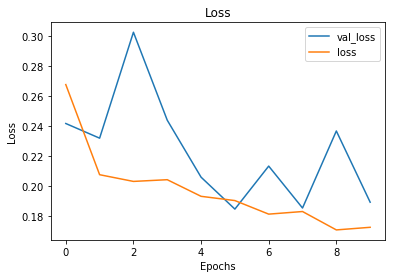

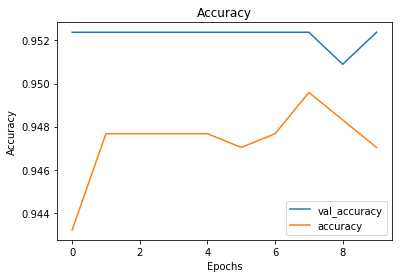

In [103]:
visualize_training_results(history6)

In [104]:
results.append('64 bits 6th model, same as last one')
results.append(['acc train',round(history6.history['acc'][-1],3)])
results.append(['acc valid',round(history6.history['val_acc'][-1],3)])
results.append(['loss train',round(history6.history['loss'][-1],3)])
results.append(['loss valid',round(history6.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21],
 '8 bits fifth model',
 ['acc train', 0.912],
 ['acc valid', 0.951],
 ['loss train', 0.384],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.943],
 ['acc valid', 0.963],
 ['loss train', 0.218],
 ['loss valid', 0.164],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid', 0.952],
 ['loss train', 0.173],
 ['loss valid', 0.189]]

#### Increasing number of epochs:

In [105]:
history7 = model6.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.3)

Epoch 1/30
157/157 [==============================] - 2s 14ms/step - loss: 0.1680 - acc: 0.9483 - val_loss: 0.1843 - val_acc: 0.9509
Epoch 2/30
157/157 [==============================] - 2s 14ms/step - loss: 0.1618 - acc: 0.9489 - val_loss: 0.2476 - val_acc: 0.9405
Epoch 3/30
157/157 [==============================] - 2s 14ms/step - loss: 0.1576 - acc: 0.9496 - val_loss: 0.2504 - val_acc: 0.9524
Epoch 4/30
157/157 [==============================] - 2s 15ms/step - loss: 0.1545 - acc: 0.9496 - val_loss: 0.1988 - val_acc: 0.9509
Epoch 5/30
157/157 [==============================] - 2s 14ms/step - loss: 0.1582 - acc: 0.9483 - val_loss: 0.1852 - val_acc: 0.9509
Epoch 6/30
157/157 [==============================] - 2s 14ms/step - loss: 0.1554 - acc: 0.9521 - val_loss: 0.2453 - val_acc: 0.9524
Epoch 7/30
157/157 [==============================] - 2s 14ms/step - loss: 0.1608 - acc: 0.9515 - val_loss: 0.1930 - val_acc: 0.9509
Epoch 8/30
157/157 [==============================] - 2s 15ms/step - 

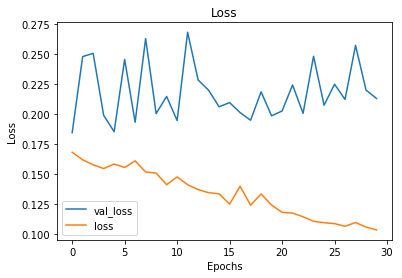

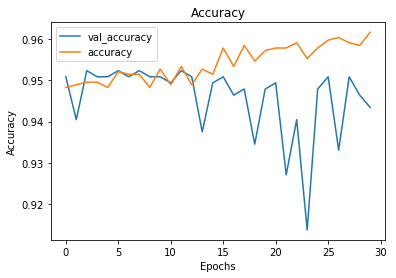

In [106]:
visualize_training_results(history7)

In [107]:
results.append('64 bits 6th model, 30 epochs')
results.append(['acc train',round(history7.history['acc'][-1],3)])
results.append(['acc valid',round(history7.history['val_acc'][-1],3)])
results.append(['loss train',round(history7.history['loss'][-1],3)])
results.append(['loss valid',round(history7.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21],
 '8 bits fifth model',
 ['acc train', 0.912],
 ['acc valid', 0.951],
 ['loss train', 0.384],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.943],
 ['acc valid', 0.963],
 ['loss train', 0.218],
 ['loss valid', 0.164],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid', 0.952],
 ['loss train', 0.173],
 ['loss valid', 0.189],
 '64 bits 6th model, 30 epochs',
 ['acc train', 0.962],
 ['acc valid', 0.943],


#### Adding more layers:

In [108]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(10, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [109]:
history8 = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.3)

Epoch 1/30
157/157 [==============================] - 6s 36ms/step - loss: 0.2738 - acc: 0.9413 - val_loss: 0.2002 - val_acc: 0.9524
Epoch 2/30
157/157 [==============================] - 5s 35ms/step - loss: 0.2278 - acc: 0.9477 - val_loss: 0.1916 - val_acc: 0.9524
Epoch 3/30
157/157 [==============================] - 5s 33ms/step - loss: 0.2184 - acc: 0.9477 - val_loss: 0.1959 - val_acc: 0.9524
Epoch 4/30
157/157 [==============================] - 6s 36ms/step - loss: 0.2156 - acc: 0.9477 - val_loss: 0.2634 - val_acc: 0.9524
Epoch 5/30
157/157 [==============================] - 5s 34ms/step - loss: 0.2138 - acc: 0.9477 - val_loss: 0.1806 - val_acc: 0.9524
Epoch 6/30
157/157 [==============================] - 5s 34ms/step - loss: 0.2064 - acc: 0.9477 - val_loss: 0.1879 - val_acc: 0.9524
Epoch 7/30
157/157 [==============================] - 5s 33ms/step - loss: 0.2044 - acc: 0.9477 - val_loss: 0.2018 - val_acc: 0.9524
Epoch 8/30
157/157 [==============================] - 5s 34ms/step - 

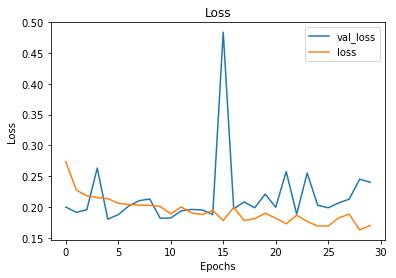

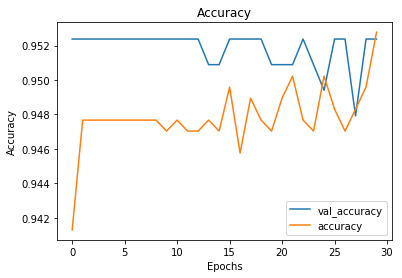

In [110]:
visualize_training_results(history8)

In [111]:
results.append('64 bits 6th model, 30 epochs, more layers')
results.append(['acc train',round(history8.history['acc'][-1],3)])
results.append(['acc valid',round(history8.history['val_acc'][-1],3)])
results.append(['loss train',round(history8.history['loss'][-1],3)])
results.append(['loss valid',round(history8.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21],
 '8 bits fifth model',
 ['acc train', 0.912],
 ['acc valid', 0.951],
 ['loss train', 0.384],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.943],
 ['acc valid', 0.963],
 ['loss train', 0.218],
 ['loss valid', 0.164],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid', 0.952],
 ['loss train', 0.173],
 ['loss valid', 0.189],
 '64 bits 6th model, 30 epochs',
 ['acc train', 0.962],
 ['acc valid', 0.943],


#### Increase the batch size:

In [112]:
history9 = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=50, validation_split=0.3)

Epoch 1/30
32/32 [==============================] - 4s 127ms/step - loss: 0.1468 - acc: 0.9502 - val_loss: 0.2062 - val_acc: 0.9524
Epoch 2/30
32/32 [==============================] - 4s 119ms/step - loss: 0.1404 - acc: 0.9509 - val_loss: 0.2434 - val_acc: 0.9509
Epoch 3/30
32/32 [==============================] - 5s 146ms/step - loss: 0.1378 - acc: 0.9515 - val_loss: 0.3285 - val_acc: 0.9494
Epoch 4/30
32/32 [==============================] - 4s 124ms/step - loss: 0.1402 - acc: 0.9509 - val_loss: 0.3003 - val_acc: 0.9524
Epoch 5/30
32/32 [==============================] - 4s 130ms/step - loss: 0.1343 - acc: 0.9515 - val_loss: 0.2278 - val_acc: 0.9435
Epoch 6/30
32/32 [==============================] - 3s 105ms/step - loss: 0.1342 - acc: 0.9541 - val_loss: 0.2350 - val_acc: 0.9509
Epoch 7/30
32/32 [==============================] - 3s 104ms/step - loss: 0.1356 - acc: 0.9509 - val_loss: 0.2352 - val_acc: 0.9301
Epoch 8/30
32/32 [==============================] - 4s 110ms/step - loss: 0.

In [113]:
y_hat_train=model.predict(train_img)
y_hat_test=model.predict(test_img)

In [114]:
y_hat_train

array([[6.2247217e-01, 3.7752783e-01, 3.8155264e-19, ..., 2.4275639e-19,
        5.8841839e-19, 1.1362670e-19],
       [9.9966288e-01, 3.3711700e-04, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9986875e-01, 1.3124100e-04, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [5.6311053e-01, 4.3688950e-01, 4.3535824e-19, ..., 4.8434697e-19,
        5.8116200e-19, 3.1602053e-19],
       [1.0000000e+00, 3.3002760e-11, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9143922e-01, 8.5607506e-03, 7.7439649e-30, ..., 6.8248774e-31,
        1.8729731e-28, 9.8005309e-31]], dtype=float32)

Clearly here I have to round to get the actual prediction for the class.

In [115]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [116]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

pr_train=precision_score(train_labels, train_labels, average=None)
#rec_train=recall_score(train_labels, y_hat_train)
#acc_train=accuracy_score(train_labels, y_hat_train)
#f1_train=f1_score(train_labels, y_hat_train)

#pr_test=precision_score(test_labels, y_hat_test)
#rec_test=recall_score(test_labels, y_hat_test)
#acc_test=accuracy_score(test_labels, y_hat_test)
#f1_test=f1_score(test_labels, y_hat_test)
pr_train
#print("Train: \nprecision", pr_train,"\nrecall:", rec_train, '\naccuracy:', acc_train, '\nf1 score:', f1_train,'\n')
#print("Test: \nprecision", pr_test,"\nrecall:", rec_test, '\naccuracy:', acc_test, '\nf1 score:', f1_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

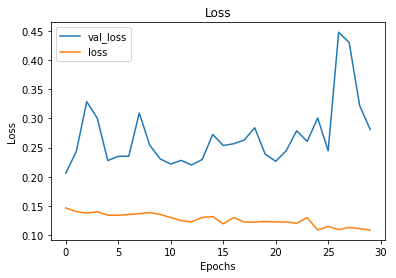

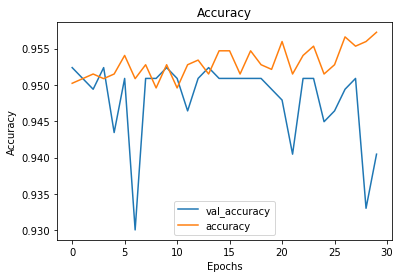

In [117]:
visualize_training_results(history9)

In [118]:
results.append('64 bits 6th model, increased batch size')
results.append(['acc train',round(history9.history['acc'][-1],3)])
results.append(['acc valid',round(history9.history['val_acc'][-1],3)])
results.append(['loss train',round(history9.history['loss'][-1],3)])
results.append(['loss valid',round(history9.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.954],
 ['acc valid', 0.933],
 ['loss train', 0.193],
 ['loss valid', 1.082],
 '32 bits second model, larger batch',
 ['acc train', 0.961],
 ['acc valid', 0.924],
 ['loss train', 0.097],
 ['loss valid', 0.568],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.949],
 ['acc valid', 0.949],
 ['loss train', 0.191],
 ['loss valid', 0.268],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.948],
 ['acc valid', 0.955],
 ['loss train', 0.193],
 ['loss valid', 0.21],
 '8 bits fifth model',
 ['acc train', 0.912],
 ['acc valid', 0.951],
 ['loss train', 0.384],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.943],
 ['acc valid', 0.963],
 ['loss train', 0.218],
 ['loss valid', 0.164],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid', 0.952],
 ['loss train', 0.173],
 ['loss valid', 0.189],
 '64 bits 6th model, 30 epochs',
 ['acc train', 0.962],
 ['acc valid', 0.943],


#### Changing activation functions and optimizations:
Some of the options for activation functions are:
<br>relu
<br>swish
<br>softmax
<br>leaky relu
<br>sigmoid

<br>for optimizers:
<br>adam, sgd, 
<br>with optimizer I can also tweak the learning rate

<br>for loss functions:
categorical_crossentropy, 


In [119]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(10, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

maybe Even make a graph with this learning curve.
Can do it within the pipeline?